In [1]:
import pandas as pd
import json
from tqdm.auto import tqdm
import gc
tqdm.pandas()

In [2]:
paths = ['/kaggle/input/twitter-activity-data-users-p1/activity_timelines_1.json',
 '/kaggle/input/twitter-activity-data-users-p2/activity_timelines_2.json',
 '/kaggle/input/twitter-activity-data-users-p3/activity_timelines_3.json',
 '/kaggle/input/twitter-activity-data-users-p4-final/activity_timelines_4.json',
 '/kaggle/input/twitter-activity-data-users-p5/activity_timelines_5.json',
 '/kaggle/input/twitter-activity-data-users-p6/activity_timelines_6.json',
 '/kaggle/input/twitter-activity-data-users-p7/activity_timelines_7.json',
 '/kaggle/input/twitter-activity-data-users-p8/activity_timelines_8.json',
 '/kaggle/input/of-twitter-activity-data-users-p9/activity_timelines_9.json',
 '/kaggle/input/twitter-activity-data-users-p10/activity_timelines_10.json']

In [3]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 3.6 MB/s eta 0:00:00 0:00:01


In [4]:
activity_data = []
for i in paths:
    activity_data.append(json.load(open(i)))

In [5]:
posts = []
for i in activity_data:
    for j in i:
        for k in j:
            posts.append(k['text'])

In [7]:
from sentence_transformers import SentenceTransformer
model1 = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device = 'cuda') # small and fast
model2 = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2', device = 'cuda') # multilingual
model3 = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device = 'cuda') # large
model4 = SentenceTransformer('jinaai/jina-embeddings-v2-base-en', device = 'cuda') # SOTA

Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-base-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.10.output.LayerNorm.bias', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.10.output.dense.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.11.intermediate.dense.bias', 'encoder.layer.11.intermedi

In [9]:
profile_data = pd.read_csv('/kaggle/input/concatenate-twitter-data/main_df_users.csv')
profile_data.head()

,timestamp,user,bio,tweettext
0,Mon Apr 15 19:36:44 +0000 2024,jc_talkz,NaN,“Being happy never goes out of style.”🇵🇹
1,Sat Apr 13 20:59:21 +0000 2024,Luna Lux Legacy,"Passionately seeking judicial reform, specific...",https://t.co/tziQasjVFq
2,Sat Apr 13 20:59:15 +0000 2024,Luna Lux Legacy,"Passionately seeking judicial reform, specific...",https://t.co/r8Ua5eW2Sg
3,Sat Apr 13 20:32:02 +0000 2024,Luna Lux Legacy,"Passionately seeking judicial reform, specific...",https://t.co/HepEBC7rU4
4,Sat Apr 13 20:25:37 +0000 2024,Luna Lux Legacy,"Passionately seeking judicial reform, specific...",https://t.co/iJH7M0KtgY


In [10]:
posts = profile_data['tweettext']
e1 = model1.encode(posts)
e2 = model2.encode(posts)
e3 = model3.encode(posts)
e4 = model4.encode(posts)

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
def calculate_diversity(embeddings):
    summed_array = np.nan_to_num(np.array([i.sum(axis =0) for i in  embeddings]), 0)
    return 1-sum(sum(cosine_similarity(summed_array)))/(summed_array.shape[0]**2)


In [18]:
static_diversities = {}
static_diversities['MiniLM'] = calculate_diversity([e1])
static_diversities['Multi'] = calculate_diversity([e2])
static_diversities['mpnet'] = calculate_diversity([e3])
static_diversities['jina'] = calculate_diversity([e4])

In [24]:
static_diversities

{'MiniLM': 0.2384185791015625,
 'Multi': 0.27881393432617185,
 'mpnet': 0.361625671386717,
 'jina': 0.1920928955078124}

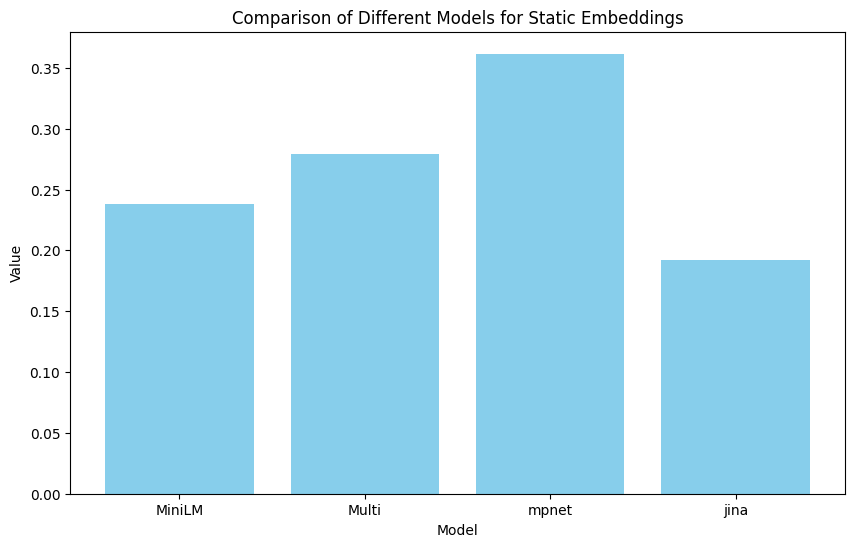

In [27]:
import matplotlib.pyplot as plt
data = static_diversities
plt.figure(figsize=(10, 6))
plt.bar(data.keys(), data.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('Value')
plt.title('Comparison of Different Models for Static Embeddings')
plt.show()

for diversity, the maximum value for static embeddings was by mpnet : 0.36, which is very much less than compared to the dynamic embedding diversities. 
This might be because, for static embeddings, the we did mean of all the tweets instead of a decay. this greatly reduced the uniqueness of a profile and hence reduced the diveristu

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Dense, Lambda
import tensorflow.keras.backend as K

def create_model():
    input1 = Input(shape=(512,))
    input2 = Input(shape=(512,))

    dense1 = Dense(256, activation='relu')(input1)
    dense1 = Dense(128, activation='relu')(dense1)
    dense1 = Dense(64, activation='relu')(dense1)

    dense2 = Dense(256, activation='relu')(input2)
    dense2 = Dense(128, activation='relu')(dense2)
    dense2 = Dense(64, activation='relu')(dense2)

    def cosine_similarity(inputs):
        x, y = inputs
        x = K.l2_normalize(x, axis=-1)
        y = K.l2_normalize(y, axis=-1)
        return K.sum(x * y, axis=-1, keepdims=True)

    cos_sim = Lambda(cosine_similarity)([dense1, dense2])

    model = Model(inputs=[input1, input2], outputs=cos_sim)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model


In [13]:
def train_evaluate(file, e):
    input_1 = np.load(file)
    input_2 = e
    model = create_model()
    model.fit(input_1, input_2,1)
    return K.mean(K.sigmoid(model.predict(input_1, input_2)))

In [ ]:
m1 = train_evaluate(e1, activity_data)
m2 = train_evaluate(e1, activity_data)
m3 = train_evaluate(e1, activity_data)
m4 = train_evaluate(e1, activity_data)

In [29]:
m1,m2,m3,m4

(0.01782471, 0.25269645, 0.31811421, 0.39415552)

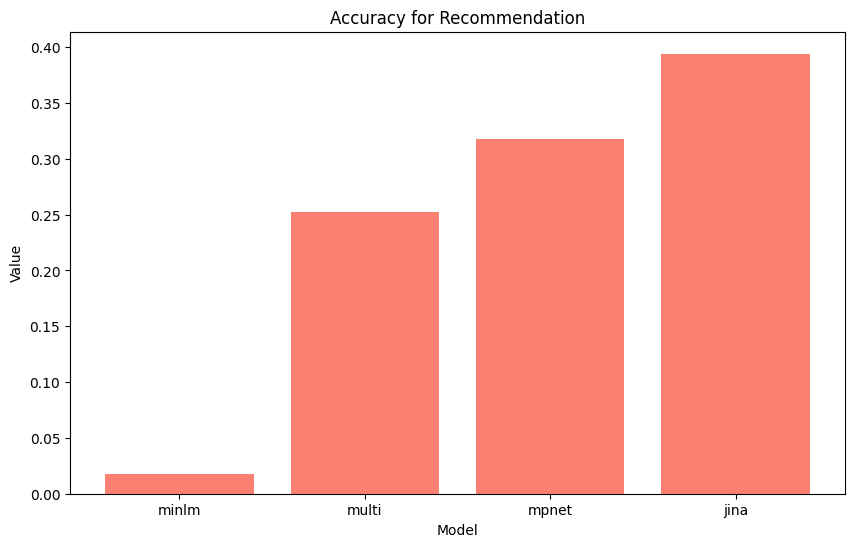

In [30]:
# Data for the bar plot
marray = [m1,m2,m3,m4]
# Creating the bar plot with updated title and x-axis labels
x_labels = ['minlm', 'multi', 'mpnet', 'jina']

plt.figure(figsize=(10, 6))
plt.bar(x_labels, marray, color='salmon')
plt.xlabel('Model')
plt.ylabel('Value')
plt.title('Accuracy for Recommendation')
plt.show()


jina static embeddings perform the best for accurately identifying recomendations. but its still less than dynamic embeddings. the aggregated static embeddings fail to match the user profile to the activities.